---
# **PREREQUISITES AND IMPORTS**

In [ ]:
!apt-get install -y lz4
!pip install matplotlib
!pip install gdown
!pip install paddlepaddle-gpu==3.1.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu126/
!pip install paddleocr
!pip install editdistance
!pip install yolov5
!pip install ultralytics
!pip install albumentations

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  lz4
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 90.0 kB of archives.
After this operation, 236 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 lz4 amd64 1.9.3-2build2 [90.0 kB]
Fetched 90.0 kB in 0s (251 kB/s)
Selecting previously unselected package lz4.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../lz4_1.9.3-2build2_amd64.deb ...
Unpacking lz4 (1.9.3-2build2) ...
Setting up lz4 (1.9.3-2build2) ...
Processing triggers for man-db (2.10.2-1) ...
Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu126/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 GB 873.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%matplotlib inline

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import zipfile
import subprocess
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont
import random
from tqdm import tqdm
from pathlib import Path
import cv2
import warnings
import editdistance
import yolov5
import albumentations as A
from albumentations.pytorch import ToTensorV2
import shutil
from matplotlib import font_manager
import inspect
import sys
import torch.nn.modules as nn_modules
from paddleocr import PaddleOCR
from paddle import get_device
import json
import threading

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

---
# **GLOBAL VARIABLES AND PARAMETERS**

In [ ]:
BASE_DIR = os.getcwd()  # Root directory for project
print(f"BASE_DIR: {BASE_DIR}")

FONT_PATH = f"{BASE_DIR}/CCPD/NotoSansTC-VariableFont_wght.ttf"  # Font for writing plate characters

YOLO_WEIGHTS_PATH = f'{BASE_DIR}/yolov5/runs/train/ccpd_yolo_baseline/weights/best.pt' # Path to the weights of the trained detection YOLO model
YOLO_MODEL = "yolov5m"  # Type of YOLO detection model

RECOGNITION_MODEL_PATH = f"{BASE_DIR}/recognition_model.pth"  # Path to trained recognition model

TRAIN_DATASET = f'{BASE_DIR}/CCPD2019/ccpd_train' # Path to training dataset
VAL_DATASET = f'{BASE_DIR}/CCPD2019/ccpd_val' #Path to validation dastaset
print(f"TRAIN_DATASET: {TRAIN_DATASET}")
print(f"VAL_DATASET: {VAL_DATASET}")
FILENAME_SPLITTER = '&'

BASE_DIR: /content
TRAIN_DATASET: /content/CCPD2019/ccpd_train
VAL_DATASET: /content/CCPD2019/ccpd_val


In [ ]:
USE_YOLO = True # Use YOLO for detection in pipeline?

BATCH_SIZE = 32

# --- Training Configuration for Detection
NUM_SAMPLES_DET = 20000
NUM_EPOCHS_DET = 20
IOU_THRESHOLD_DET = 0.5
LEARNING_RATE_DET = 1e-3

# --- Training Configuration for Recognition ---
NUM_SAMPLES_REC = 20000
RECOGNITION_EPOCHS = 30
PLATE_CROP_TARGET_SIZE = (64, 128)
LEARNING_RATE_REC = 1e-3

# --- Pipeline Evaluation Parameters ---
PIPELINE_IOU = 0.5
PIPELINE_CONFIDENCE = 0.25

# --- YOLOv5 + PDLPR Parameters
NUM_SAMPLES_YOLO_PDLPR = 20000
CONF_THRESHOLD_YOLO_PDLPR = 0.25
IOU_THRESHOLD_YOLO_PDLPR = 0.5

---
# **DATASET PREPARATION**

## Download and decompress dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/19lbkl8seJ56jQuj7hVq5sv5Dj-G4RvM-?usp=sharing

Retrieving folder contents
Processing file 1isPOnFzFXBd35Rk_bWiVjpVcCVssO_0q ccpd_train.tar.lz4
Processing file 1SIeRKfz7JvpXPG-VvDxhs1ry0N4m-zyy ccpd_val.tar.lz4
Processing file 1Smvr3gTDAed6K6mW5yZDSx--bsEU6Gat NotoSansSC-VariableFont_wght.ttf
Processing file 1_u2OTTt2l81jIhS0PTP6ekpfkchfHdoZ NotoSansTC-VariableFont_wght.ttf
Processing file 1zf9h8MOrdvN-FhqJyOf-xsaqOIkZMyfe paddle_ocr_worker.py
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1isPOnFzFXBd35Rk_bWiVjpVcCVssO_0q
From (redirected): https://drive.google.com/uc?id=1isPOnFzFXBd35Rk_bWiVjpVcCVssO_0q&confirm=t&uuid=ce67cc35-a4a8-4bb5-8ba8-e04eff6644a4
To: /content/CCPD/ccpd_train.tar.lz4
100% 6.57G/6.57G [06:05<00:00, 18.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SIeRKfz7JvpXPG-VvDxhs1ry0N4m-zyy
From (redirected): https://drive.google.com/uc?id=1SIeRKfz7JvpXPG-VvDxhs1ry0N4m-zyy&con

Decompress split dataset

In [ ]:
if not os.path.exists(f"{BASE_DIR}/CCPD2019"):
    os.makedirs(f"{BASE_DIR}/CCPD2019")
print(f"{BASE_DIR}/CCPD/ccpd_train.tar.lz4")
subprocess.run(["tar", "--use-compress-program=lz4", "-xvf", f"{BASE_DIR}/CCPD/ccpd_train.tar.lz4", "-C", f"{BASE_DIR}/CCPD2019"], check=True)
subprocess.run(["tar", "--use-compress-program=lz4", "-xvf", f"{BASE_DIR}/CCPD/ccpd_val.tar.lz4", "-C", f"{BASE_DIR}/CCPD2019"], check=True)

/content/CCPD/ccpd_train.tar.lz4


CompletedProcess(args=['tar', '--use-compress-program=lz4', '-xvf', '/content/CCPD/ccpd_val.tar.lz4', '-C', '/content/CCPD2019'], returncode=0)

## Define the dataset and the transforms

We define the Pytorch dataset structure and the function to extract labels from filenames

In [ ]:
class CCPDDataset(Dataset):
    def __init__(self, data_dir, split_file=None, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        all_image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]

        print(f"Found {len(all_image_files)} image files in the data directory.")

        # If a split file is provided, filter the image files
        if split_file:
            if not os.path.exists(split_file):
                print(f"Warning: Split file not found at {split_file}")
                self.image_files = [] # No files if split file is missing
            else:
                print("Splitting")
                with open(split_file, 'r') as f:
                    split_filenames = [line.strip().replace('ccpd_base/', '') for line in f if line.strip()]

                # Filter image files to include only those in the split file
                self.image_files = [f for f in all_image_files if os.path.basename(f) in split_filenames]
                print(f"Found {len(self.image_files)} image files matching the split file.")
        else:
            self.image_files = all_image_files
            print("No split file provided, using all image files.")


        # Character mappings
        self.provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
        self.alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
                          'X', 'Y', 'Z', 'O']
        self.ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                    'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        bbox, char_indices = self._extract_annotations_from_filename(os.path.basename(img_path))

        license_plate_string = self._indices_to_string(char_indices)

        image_np = np.array(image)

        img_h, img_w = image_np.shape[:2]

        bbox_abs = [
            bbox[0],
            bbox[1],
            bbox[2],
            bbox[3]
        ]

        if self.transform:
            transformed = self.transform(
                image=image_np,
                bboxes=[bbox_abs],
                class_labels=[0]
            )
            image = transformed['image']

            if len(transformed['bboxes']) == 0:
                # fallback
                bbox_transformed = bbox_abs
            else:
                bbox_transformed = transformed['bboxes'][0]

            # If transform: normalize relative to 416
            bbox_final = [
                bbox_transformed[0] / 416,
                bbox_transformed[1] / 416,
                bbox_transformed[2] / 416,
                bbox_transformed[3] / 416,
            ]

            bbox = torch.tensor(bbox_final, dtype=torch.float32)

        else:
            # If no transform: normalize relative to original
            bbox_norm = [
                bbox_abs[0] / img_w,
                bbox_abs[1] / img_h,
                bbox_abs[2] / img_w,
                bbox_abs[3] / img_h,
            ]
            image = transforms.ToTensor()(image)
            bbox = torch.tensor(bbox_norm, dtype=torch.float32)

        return image, bbox, license_plate_string, torch.tensor(char_indices, dtype=torch.long)

    def _extract_annotations_from_filename(self, filename):
        filename_no_ext = os.path.splitext(filename)[0]
        # print("\nfilename_no_ext", filename_no_ext)
        parts = filename_no_ext.split('-')

        # Extract Bounding box coordinates (field 3, index 2)
        # The format is "x1&y1_x2&y2" (left-up and right-bottom)
        bbox_coords_str = parts[2].split('_')
        # print("bbox_coords_str", bbox_coords_str)

        # Split by '&' to get x and y for left-up and right-bottom
        left_up = [int(coord) for coord in bbox_coords_str[0].split(FILENAME_SPLITTER)]
        right_bottom = [int(coord) for coord in bbox_coords_str[1].split(FILENAME_SPLITTER)]

        # Bounding box in (x1, y1, x2, y2) format
        bbox = (left_up[0], left_up[1], right_bottom[0], right_bottom[1])
        # print("Bounding box: (", left_up[0], ",", left_up[1], ",", right_bottom[0], ",", right_bottom[1], ")")

        # Extract Four vertices locations (field 4, index 3)
        # The format is "x1&y1_x2&y2_x3&y3_x4&y4" (starting from right-bottom)
        vertices_str = parts[3].split('_')
        vertices = []
        for vertex_str in vertices_str:
            vertices.append([int(coord) for coord in vertex_str.split(FILENAME_SPLITTER)])

        # Extract License plate number (field 5, index 4)
        # The format is "0_0_22_27_27_33_16" (indices of characters)
        char_indices_str = parts[4].split('_') # Corrected index to 4
        char_indices = [int(index) for index in char_indices_str]
        # print("Char indices:", char_indices) # Added for debugging

        # Extract Brightness (field 6, index 5)
        brightness = int(parts[5])

        # Extract Blurriness (field 7, index 6)
        blurriness = int(parts[6])

        return bbox, char_indices

    def _indices_to_string(self, char_indices):
        # Map indices to characters based on their position
        # The format is province, alphabet, and then five from ads
        license_plate = ""
        if len(char_indices) > 0:
            license_plate += self.provinces[char_indices[0]]
        if len(char_indices) > 1:
            license_plate += self.alphabets[char_indices[1]]
        for i in range(2, min(len(char_indices), 7)):
            license_plate += self.ads[char_indices[i]]

        return license_plate

class SmallSubsetDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, max_samples=100, random_subset=False):
        self.base_dataset = base_dataset
        self.max_samples = min(max_samples, len(base_dataset))

        if random_subset:
            self.image_files = random.sample(base_dataset.image_files, self.max_samples)
        else:
            self.image_files = base_dataset.image_files[:self.max_samples]

        self.provinces = base_dataset.provinces
        self.alphabets = base_dataset.alphabets
        self.ads = base_dataset.ads

    def __len__(self):
        return self.max_samples

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        original_idx = self.base_dataset.image_files.index(img_file)
        return self.base_dataset[original_idx]
    def _indices_to_string(self, indices):
        return self.base_dataset._indices_to_string(indices)

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    bboxes = torch.stack([item[1] for item in batch])
    license_plate_strings = [item[2] for item in batch]
    char_indices = torch.stack([item[3] for item in batch])

    return images, bboxes, license_plate_strings, char_indices

We define the transforms to apply to the images

In [ ]:
# Transform size
height = 416
width = 416

transform_train = A.Compose([
    A.Resize(height=416, width=416),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(p=0.1),
        A.GaussNoise(p=0.2)
    ], p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.02, scale_limit=0.1, rotate_limit=5,
        border_mode=0, p=0.5
    ),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
],
    bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['class_labels'],
        min_visibility=0.0,
        #filter_lost_elements=True
    )
)


transform_val = A.Compose([
    A.Resize(height=416, width=416),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
)

---
# **BASELINE MODEL - DETECTION**

## Define the dataset

In [ ]:
train_dataset = CCPDDataset(data_dir=TRAIN_DATASET, transform=transform_train)
val_dataset = CCPDDataset(data_dir=VAL_DATASET, transform=transform_val)

Found 100000 image files in the data directory.
No split file provided, using all image files.
Found 99996 image files in the data directory.
No split file provided, using all image files.


Optional: take a subsample of the dataset

In [ ]:
train_dataset = SmallSubsetDataset(train_dataset, max_samples=NUM_SAMPLES_DET, random_subset=True)
val_dataset = SmallSubsetDataset(val_dataset, max_samples=NUM_SAMPLES_DET, random_subset=True)
print(f"Subset of train dataset has size {len(train_dataset)}")
print(f"Subset of evaluation dataset has size {len(val_dataset)}")

Subset of train dataset has size 20000
Subset of evaluation dataset has size 20000


Create dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the evaluation dataset: {len(val_dataset)}")

Number of images in the training dataset: 20000
Number of images in the evaluation dataset: 20000


## Optional: visualize the dataset



---*** TRAINING DATASET ***---

--- Sample 0 ---
Original filename: 0113936781609-89_82-287&488_495&563-508&573_288&564_268&492_488&501-0_0_8_17_33_27_29-104-10.jpg
Bounding box: tensor([0.32349, 0.41342, 0.59428, 0.48212])
License plate string: 皖AJT935
Character indices tensor: tensor([ 0,  0,  8, 17, 33, 27, 29])


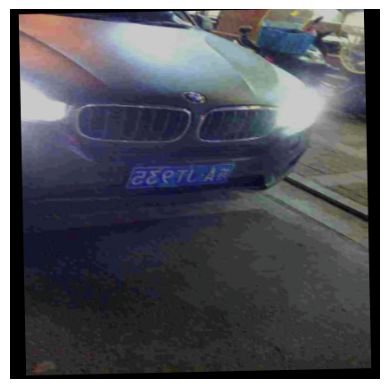


--- Sample 1 ---
Original filename: 0213218390805-94_86-210&496_453&585-461&598_200&573_198&489_459&514-0_0_23_33_32_29_22-149-55.jpg
Bounding box: tensor([0.36114, 0.43933, 0.68389, 0.53306])
License plate string: 皖AZ985Y
Character indices tensor: tensor([ 0,  0, 23, 33, 32, 29, 22])


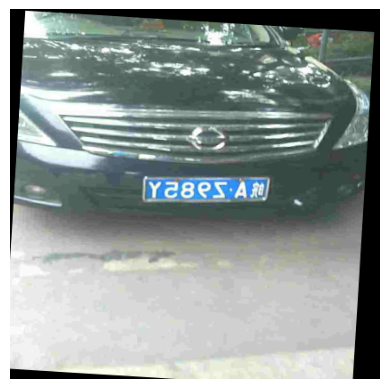


--- Sample 2 ---
Original filename: 0185296934866-89_87-220&456_466&550-474&550_214&543_207&455_467&462-0_0_21_27_25_24_18-96-15.jpg
Bounding box: tensor([0.29876, 0.37290, 0.66566, 0.48131])
License plate string: 皖AX310U
Character indices tensor: tensor([ 0,  0, 21, 27, 25, 24, 18])


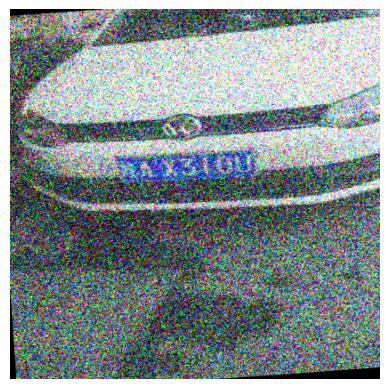


--- Sample 3 ---
Original filename: 011875-88_88-306&441_490&512-499&503_319&509_313&445_493&439-0_0_8_3_32_27_30-138-32.jpg
Bounding box: tensor([0.29807, 0.39329, 0.57324, 0.45005])
License plate string: 皖AJD836
Character indices tensor: tensor([ 0,  0,  8,  3, 32, 27, 30])


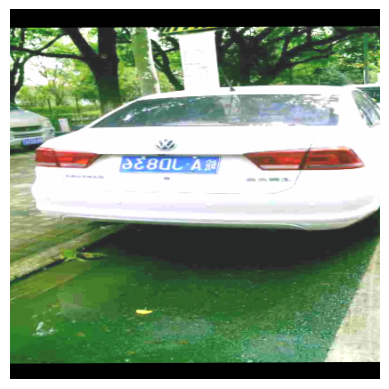


--- Sample 4 ---
Original filename: 0845809386973-102_72-109&432_561&611-563&632_125&535_104&423_542&520-0_0_27_25_30_11_33-88-198.jpg
Bounding box: tensor([0.17159, 0.38059, 0.76073, 0.54521])
License plate string: 皖A316M9
Character indices tensor: tensor([ 0,  0, 27, 25, 30, 11, 33])


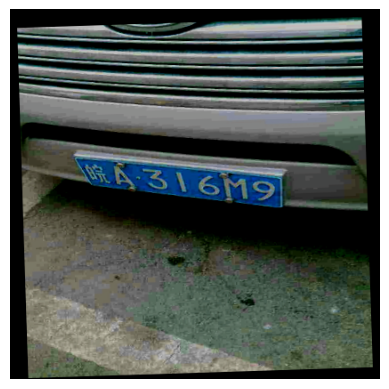



---*** EVALUATION DATASET ***---

--- Sample 0 ---
Original filename: 0206896551724-90_86-193&503_447&600-454&593_201&593_206&496_459&496-0_0_31_27_31_9_25-99-54.jpg
Bounding box: tensor([0.26806, 0.43362, 0.62083, 0.51724])
License plate string: 皖A737K1
Character indices tensor: tensor([ 0,  0, 31, 27, 31,  9, 25])


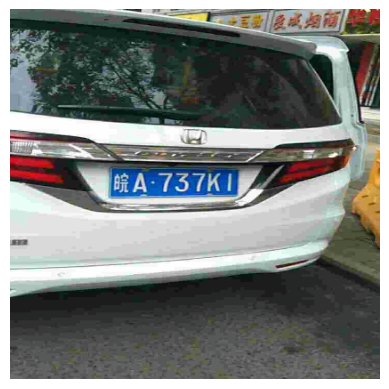


--- Sample 1 ---
Original filename: 0322844827586-91_85-199&403_543&502-541&509_207&496_202&399_536&412-0_0_4_12_32_25_30-148-154.jpg
Bounding box: tensor([0.27639, 0.34741, 0.75417, 0.43276])
License plate string: 皖AEN816
Character indices tensor: tensor([ 0,  0,  4, 12, 32, 25, 30])


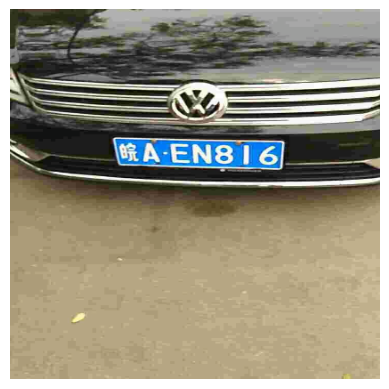


--- Sample 2 ---
Original filename: 0137176724138-91_91-210&427_420&511-430&508_209&501_206&425_427&432-0_0_6_28_28_28_8-116-58.jpg
Bounding box: tensor([0.29167, 0.36810, 0.58333, 0.44052])
License plate string: 皖AG444J
Character indices tensor: tensor([ 0,  0,  6, 28, 28, 28,  8])


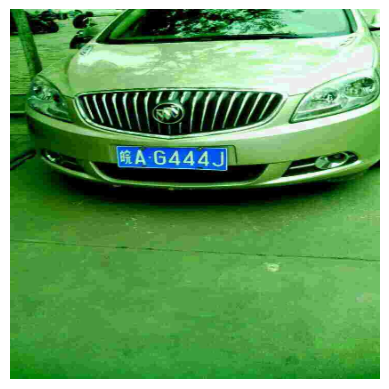


--- Sample 3 ---
Original filename: 0204370210728-103_73-424&479_609&591-611&598_439&548_431&476_603&526-0_0_2_28_21_30_30-92-12.jpg
Bounding box: tensor([0.58889, 0.41293, 0.84583, 0.50948])
License plate string: 皖AC4X66
Character indices tensor: tensor([ 0,  0,  2, 28, 21, 30, 30])


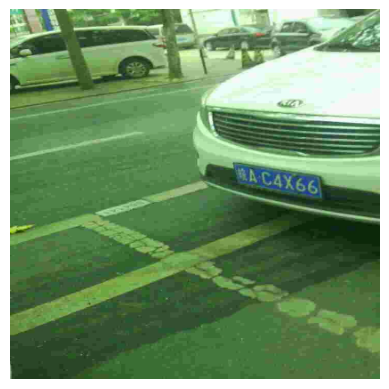


--- Sample 4 ---
Original filename: 0338362068966-91_85-176&472_505&583-510&585_170&567_163&469_503&487-0_0_16_27_16_25_30-108-58.jpg
Bounding box: tensor([0.24444, 0.40690, 0.70139, 0.50259])
License plate string: 皖AS3S16
Character indices tensor: tensor([ 0,  0, 16, 27, 16, 25, 30])


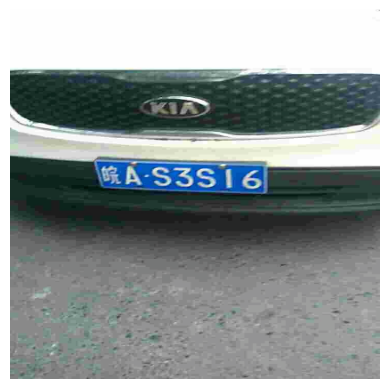

In [ ]:
num_samples_to_check = 5 # Number of samples to inspect

def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img.numpy().transpose((1, 2, 0)) + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

print("\n\n---*** TRAINING DATASET ***---")
for i in range(num_samples_to_check):
    image, bbox, license_plate_string, char_indices_tensor = train_dataset[i]

    print(f"\n--- Sample {i} ---")
    print("Original filename:", os.path.basename(train_dataset.image_files[i]))
    print("Bounding box:", bbox)
    print("License plate string:", license_plate_string)
    print("Character indices tensor:", char_indices_tensor)
    imshow(image)

print("\n\n---*** EVALUATION DATASET ***---")
for i in range(num_samples_to_check):
    image, bbox, license_plate_string, char_indices_tensor = val_dataset[i]

    print(f"\n--- Sample {i} ---")
    print("Original filename:", os.path.basename(val_dataset.image_files[i]))
    print("Bounding box:", bbox)
    print("License plate string:", license_plate_string)
    print("Character indices tensor:", char_indices_tensor)
    imshow(image)


## Load YOLO model

In [ ]:
!git clone https://github.com/ultralytics/yolov5
subprocess.run(["pip", "install", "-r", f"{BASE_DIR}/yolov5/requirements.txt"])

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (12001/12001), done.


CompletedProcess(args=['pip', 'install', '-r', '/content/yolov5/requirements.txt'], returncode=0)

In [ ]:
model = torch.hub.load("ultralytics/yolov5", YOLO_MODEL)  # Default: yolov5s

"""
# Define the input image source (URL, local file, PIL image, OpenCV frame, numpy array, or list)
img = "https://ultralytics.com/images/zidane.jpg"  # Example image

# Perform inference (handles batching, resizing, normalization automatically)
results = model(img)

# Process the results (options: .print(), .show(), .save(), .crop(), .pandas())
results.print()  # Print results to console
results.show()  # Display results in a window
results.save()  # Save results to runs/detect/exp
"""

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-7-16 Python-3.11.13 torch-2.6.0+cu124 CPU

100%|██████████| 40.8M/40.8M [00:00<00:00, 70.4MB/s]

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


'\n# Define the input image source (URL, local file, PIL image, OpenCV frame, numpy array, or list)\nimg = "https://ultralytics.com/images/zidane.jpg"  # Example image\n\n# Perform inference (handles batching, resizing, normalization automatically)\nresults = model(img)\n\n# Process the results (options: .print(), .show(), .save(), .crop(), .pandas())\nresults.print()  # Print results to console\nresults.show()  # Display results in a window\nresults.save()  # Save results to runs/detect/exp\n'

## Training

We first need to export labels by creating .txt files for each image

In [ ]:
def export_to_yolo(subset_dataset, output_dir):
    image_dir = os.path.join(output_dir, 'images')
    label_dir = os.path.join(output_dir, 'labels')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in tqdm(range(len(subset_dataset)), desc=f"Exporting to {output_dir}"):
        image, bbox, _, _ = subset_dataset[i]

        # Get original path
        if hasattr(subset_dataset, 'image_files'):
            img_path = subset_dataset.image_files[i]
        elif hasattr(subset_dataset, 'base_dataset') and hasattr(subset_dataset.base_dataset, 'image_files'):
            img_path = subset_dataset.base_dataset.image_files[i]
        else:
            raise ValueError("Cannot locate image path")

        # Save image to new folder
        new_img_path = os.path.join(image_dir, os.path.basename(img_path))
        shutil.copyfile(img_path, new_img_path)

        # Convert bbox to YOLO format (x_center, y_center, width, height)
        img_pil = Image.open(img_path).convert('RGB')
        img_w, img_h = img_pil.size

        x1 = bbox[0].item() * img_w
        y1 = bbox[1].item() * img_h
        x2 = bbox[2].item() * img_w
        y2 = bbox[3].item() * img_h

        x_center = (x1 + x2) / 2 / img_w
        y_center = (y1 + y2) / 2 / img_h
        width = (x2 - x1) / img_w
        height = (y2 - y1) / img_h

        # Save label
        label_filename = os.path.basename(img_path).replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_filename)

        with open(label_path, 'w') as f:
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


### Use the whole dataset

In [ ]:
export_to_yolo(train_dataset, f"{BASE_DIR}/CCPD2019/ccpd_train")
export_to_yolo(val_dataset, f"{BASE_DIR}/CCPD2019/ccpd_val")

In [ ]:
ccpd_yaml_path = f"{BASE_DIR}/ccpd.yaml"

with open(ccpd_yaml_path, 'w') as f:
    f.write(f"""train: {BASE_DIR}/CCPD2019/ccpd_train
val: {BASE_DIR}/CCPD2019/ccpd_val

nc: 1
names: ['license_plate']
""")

### OR use a subset

In [ ]:
export_to_yolo(train_dataset, "ccpd_subset/train")
export_to_yolo(val_dataset, "ccpd_subset/val")

Exporting to ccpd_subset/val: 100%|██████████| 20000/20000 [05:29<00:00, 60.66it/s]


In [ ]:
ccpd_yaml_path = f"{BASE_DIR}/ccpd_subset.yaml"

with open(ccpd_yaml_path, 'w') as f:
    f.write(f"""train: {BASE_DIR}/ccpd_subset/train
val: {BASE_DIR}/ccpd_subset/val

nc: 1
names: ['license_plate']
""")

### Train

#### In Colab

In [ ]:
!python -W ignore::FutureWarning -W ignore::DeprecationWarning "{BASE_DIR}/yolov5/train.py" --img 416 --batch {BATCH_SIZE} --epochs {NUM_EPOCHS_DET} --data {ccpd_yaml_path} --weights {YOLO_MODEL}.pt --name ccpd_yolo_baseline

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-16 11:33:00.627302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752665580.647663   10929 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752665580.653819   10929 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5m.pt, cfg=, data=/content/ccpd_subset.yaml, hyp=yolov5/da

#### OR In Jupyter

In [ ]:
subprocess.run([
    "python",
    "-W", "ignore::FutureWarning",
    "-W", "ignore::DeprecationWarning",
    f"{BASE_DIR}/yolov5/train.py",
    "--img", "416",
    "--batch", f"{BATCH_SIZE}",
    "--epochs", f"{NUM_EPOCHS_DET}",
    "--data", f"{ccpd_yaml_path}",
    "--weights", f"{YOLO_MODEL}.pt",
    "--name", "ccpd_yolo_baseline"
])

## Evaluation

### In Colab

In [ ]:
!python -W ignore::FutureWarning -W ignore::DeprecationWarning "{BASE_DIR}/yolov5/val.py" --data {ccpd_yaml_path} --weights {YOLO_WEIGHTS_PATH} --img 416 --task val

val: data=/content/ccpd_subset.yaml, weights=['/content/yolov5/runs/train/ccpd_yolo_baseline4/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /content/ccpd_subset/val/labels.cache... 20000 images, 0 backgrounds, 0 corrupt: 100% 20000/20000 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  91% 571/625 [04:03<00:21,  2.56it/s]

### OR In Jupyter

In [ ]:
subprocess.run([
    "python",
    f"{BASE_DIR}/yolov5/val.py",
    "--data", f"{ccpd_yaml_path}",
    "--weights", YOLO_WEIGHTS_PATH,
    "--img", "416",
    "--task", "val"
])


---
# **BASELINE MODEL - RECOGNITION**

We need to feed the recognition model only the license plate part of the image. We'll use the ground truth bounding boxes to crop these out.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def crop_license_plate(image_tensor_batch, gt_bboxes_batch, target_size=(64, 128)):
    cropped_plates = []
    _, _, H, W = image_tensor_batch.shape

    for i in range(image_tensor_batch.size(0)):
        img = image_tensor_batch[i]
        bbox = gt_bboxes_batch[i]

        # Denormalize bbox coordinates
        x1 = int(bbox[0] * W)
        y1 = int(bbox[1] * H)
        x2 = int(bbox[2] * W)
        y2 = int(bbox[3] * H)

        # Ensure coordinates are within image bounds and valid
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(W, x2)
        y2 = min(H, y2)

        crop_width = x2 - x1
        crop_height = y2 - y1

        if crop_width <= 0 or crop_height <= 0:
            # Handle invalid bbox: create a black image of target_size
            print(f"Warning: Invalid bbox {bbox} resulted in zero/negative crop size. Using black image.")
            plate_crop = torch.zeros((img.size(0), target_size[0], target_size[1]), device=img.device)
        else:
            # Crop
            plate_crop = TF.crop(img, top=y1, left=x1, height=crop_height, width=crop_width)

        # Resize the cropped plate to the target size
        plate_crop_resized = TF.resize(plate_crop, target_size, antialias=True)
        cropped_plates.append(plate_crop_resized)

    return torch.stack(cropped_plates)

This model will take the cropped license plate image (e.g., 64x128 pixels) and output predictions for each of the 7 character positions. Our model will have a shared CNN backbone to extract features from the plate, and then separate fully connected "heads" to predict each character.

In [ ]:
class LicensePlateRecognizer(nn.Module):
    def __init__(self, num_provinces, num_alphabets, num_ads, input_height=64, input_width=128):
        super().__init__()
        self.num_provinces = num_provinces
        self.num_alphabets = num_alphabets
        self.num_ads = num_ads

        # CNN Backbone
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Keep size: Bx32x64x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),      # Bx32x32x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Bx64x32x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),      # Bx64x16x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Bx128x16x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)), # Bx128x8x16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# Bx256x8x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2,1))  # Bx256x4x16
        )

        # Calculate the flattened size after conv layers
        self.flattened_size = 256 * (input_height // 16) * (input_width // 8) # Generic calculation

        # Fully Connected layers for each character
        self.fc_province = nn.Linear(self.flattened_size, num_provinces)
        self.fc_alphabet = nn.Linear(self.flattened_size, num_alphabets)

        # We need 5 'ads' characters
        self.fc_ad1 = nn.Linear(self.flattened_size, num_ads)
        self.fc_ad2 = nn.Linear(self.flattened_size, num_ads)
        self.fc_ad3 = nn.Linear(self.flattened_size, num_ads)
        self.fc_ad4 = nn.Linear(self.flattened_size, num_ads)
        self.fc_ad5 = nn.Linear(self.flattened_size, num_ads)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Get predictions for each character
        out_province = self.fc_province(x)
        out_alphabet = self.fc_alphabet(x)
        out_ad1 = self.fc_ad1(x)
        out_ad2 = self.fc_ad2(x)
        out_ad3 = self.fc_ad3(x)
        out_ad4 = self.fc_ad4(x)
        out_ad5 = self.fc_ad5(x)

        # Return as a list of tensors
        return [out_province, out_alphabet, out_ad1, out_ad2, out_ad3, out_ad4, out_ad5]

## Define the dataset

In [ ]:
train_dataset = CCPDDataset(data_dir=TRAIN_DATASET, transform=transform_train)
val_dataset = CCPDDataset(data_dir=VAL_DATASET, transform=transform_val)

Optional: take a subset of the dataset

In [ ]:
train_dataset = SmallSubsetDataset(train_dataset, max_samples=NUM_SAMPLES_REC)
val_dataset = SmallSubsetDataset(val_dataset, max_samples=NUM_SAMPLES_REC, random_subset=True)
print(f"Subset of train dataset has size {len(train_dataset)}")
print(f"Subset of evaluation dataset has size {len(val_dataset)}")

Create dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the evaluation dataset: {len(val_dataset)}")

## Training

We define the loss function. We'll use nn.CrossEntropyLoss for each of the 7 character predictions and sum them up.

In [ ]:
recognition_criterion = nn.CrossEntropyLoss()

def calculate_recognition_loss(predictions_list, char_indices_batch):
    total_loss = 0

    for i in range(7): # For each character position
        loss = recognition_criterion(predictions_list[i], char_indices_batch[:, i])
        total_loss += loss

    return total_loss

We define the training loop for the Recognition Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_provinces = len(train_dataset.provinces)
num_alphabets = len(train_dataset.alphabets)
num_ads = len(train_dataset.ads)

recognition_model = LicensePlateRecognizer(
    num_provinces=num_provinces,
    num_alphabets=num_alphabets,
    num_ads=num_ads,
    input_height=64, # Target size for cropped plates
    input_width=128  # Target size for cropped plates
).to(device)

recognition_optimizer = optim.Adam(recognition_model.parameters(), lr=LEARNING_RATE_REC)

print(f"Starting recognition model training on {device}...")
print(f"Num provinces: {num_provinces}, Num alphabets: {num_alphabets}, Num ads: {num_ads}")


for epoch in range(RECOGNITION_EPOCHS):
    recognition_model.train()
    epoch_rec_loss = 0

    # Use the same train_dataloader as for detection, but we'll process data differently
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{RECOGNITION_EPOCHS} (Recognition)")

    for i, (images_batch, gt_bboxes_batch, _, char_indices_batch) in enumerate(progress_bar):
        images_batch = images_batch.to(device)       # Full images (B, C, 416, 416)
        gt_bboxes_batch = gt_bboxes_batch.to(device) # Normalized GT bboxes (B, 4)
        char_indices_batch = char_indices_batch.to(device) # GT char indices (B, 7)

        # 1. Crop license plates using GT bounding boxes
        cropped_plates_batch = crop_license_plate(images_batch, gt_bboxes_batch, target_size=PLATE_CROP_TARGET_SIZE)
        # cropped_plates_batch should be (B, C, PLATE_CROP_TARGET_SIZE[0], PLATE_CROP_TARGET_SIZE[1])

        # 2. Forward pass through recognition model
        recognition_optimizer.zero_grad()
        # Ensure cropped_plates_batch are on the correct device
        predictions_list = recognition_model(cropped_plates_batch.to(device))

        # 3. Calculate loss
        rec_loss = calculate_recognition_loss(predictions_list, char_indices_batch)

        # 4. Backward pass and optimize
        rec_loss.backward()
        recognition_optimizer.step()

        epoch_rec_loss += rec_loss.item()
        progress_bar.set_postfix(rec_loss=epoch_rec_loss / (i + 1))

    avg_epoch_rec_loss = epoch_rec_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Recognition Training: Avg. Loss: {avg_epoch_rec_loss:.4f}")

# Save the trained recognition model
print(f"Saving recognition model to {RECOGNITION_MODEL_PATH}")
torch.save(recognition_model.state_dict(), RECOGNITION_MODEL_PATH)
print("Recognition model saved.")

print("Recognition model training finished.")

## Evaluation

We'll calculate:
*   Per-Character Accuracy: for each of the 7 positions, how often is the character correct?
*   Full Plate Accuracy: how often is the entire 7-character plate string predicted correctly?

In [ ]:
def unnormalize_image(tensor_image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Unnormalizes a tensor image."""
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean, device=tensor_image.device).view(3, 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std, device=tensor_image.device).view(3, 1, 1)

    unnormalized_image = tensor_image * std + mean
    unnormalized_image = torch.clamp(unnormalized_image, 0, 1)
    return unnormalized_image

def evaluate_recognition_model(model, dataloader, device, dataset_instance, crop_target_size, num_examples_to_show=5):
    model.eval()
    total_samples = 0

    # For per-character accuracy
    correct_chars_counts = [0] * 7
    total_chars_counts = [0] * 7

    # For full plate accuracy
    correct_full_plates = 0

    # To store some example predictions with images
    example_predictions_with_images = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating Recognition Model")
        for images_batch, gt_bboxes_batch, gt_plate_strings_batch, char_indices_batch in progress_bar:
            images_batch = images_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            char_indices_batch = char_indices_batch.to(device)

            # Crop plates
            cropped_plates_batch = crop_license_plate(images_batch, gt_bboxes_batch, target_size=crop_target_size)

            # Get predictions
            predictions_list = model(cropped_plates_batch)

            batch_size = char_indices_batch.size(0)
            total_samples += batch_size

            # Process predictions for the batch
            predicted_indices_batch = torch.zeros_like(char_indices_batch)
            for char_pos in range(7):
                predicted_indices_batch[:, char_pos] = torch.argmax(predictions_list[char_pos], dim=1)

            # Compare with ground truth
            for i in range(batch_size):
                gt_indices_sample = char_indices_batch[i]
                pred_indices_sample = predicted_indices_batch[i]

                is_full_plate_correct = True
                for char_pos in range(7):
                    total_chars_counts[char_pos] += 1
                    if gt_indices_sample[char_pos] == pred_indices_sample[char_pos]:
                        correct_chars_counts[char_pos] += 1
                    else:
                        is_full_plate_correct = False

                if is_full_plate_correct:
                    correct_full_plates += 1

                # Store some examples with their cropped images
                if len(example_predictions_with_images) < num_examples_to_show:
                    gt_str = dataset_instance._indices_to_string(gt_indices_sample.cpu().tolist())
                    pred_str = dataset_instance._indices_to_string(pred_indices_sample.cpu().tolist())

                    plate_img_tensor = cropped_plates_batch[i].cpu()

                    example_predictions_with_images.append({
                        "image": plate_img_tensor,
                        "gt": gt_str,
                        "pred": pred_str,
                        "correct": is_full_plate_correct
                    })

    # Calculate accuracies
    per_char_accuracies = [(correct_chars_counts[j] / total_chars_counts[j] if total_chars_counts[j] > 0 else 0) for j in range(7)]
    full_plate_accuracy = correct_full_plates / total_samples if total_samples > 0 else 0

    print("\n--- Recognition Evaluation Results ---")
    for j in range(7):
        print(f"Character Position {j+1} Accuracy: {per_char_accuracies[j]:.4f}")
    print(f"Full License Plate Accuracy: {full_plate_accuracy:.4f}")

    print("\n--- Example Predictions with Images ---")
    if not example_predictions_with_images:
        print("No examples to show.")
    else:
        num_examples = len(example_predictions_with_images)
        cols = min(num_examples, 3)
        rows = (num_examples + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3))
        if num_examples == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for idx, ex in enumerate(example_predictions_with_images):
            ax = axes[idx]

            img_to_show = unnormalize_image(ex['image']).permute(1, 2, 0).numpy()

            ax.imshow(img_to_show)
            title_color = 'green' if ex['correct'] else 'red'
            ax.set_title(f"GT: {ex['gt']}\nPred: {ex['pred']}", color=title_color, fontsize=10)
            ax.axis('off')

        for i in range(num_examples, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    return per_char_accuracies, full_plate_accuracy

In [ ]:
print("\nEvaluating recognition model on validation set with image examples...")
evaluate_recognition_model(
    recognition_model,
    val_dataloader,
    device,
    val_dataset,
    PLATE_CROP_TARGET_SIZE,
    num_examples_to_show=10
)

### Alternative: Evaluation without showing images

In [ ]:
def evaluate_recognition_model(model, dataloader, device, dataset_instance, crop_target_size):
    model.eval()
    total_samples = 0

    # For per-character accuracy
    correct_chars_counts = [0] * 7 # One counter for each of the 7 character positions
    total_chars_counts = [0] * 7

    # For full plate accuracy
    correct_full_plates = 0

    # To store some example predictions
    example_predictions = []
    max_examples_to_show = 5

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating Recognition Model")
        for images_batch, gt_bboxes_batch, gt_plate_strings_batch, char_indices_batch in progress_bar:
            images_batch = images_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            char_indices_batch = char_indices_batch.to(device) # (B, 7)

            # 1. Crop plates
            cropped_plates_batch = crop_license_plate(images_batch, gt_bboxes_batch, target_size=crop_target_size)

            # 2. Get predictions
            predictions_list = model(cropped_plates_batch.to(device)) # List of 7 tensors (B, Num_Classes)

            batch_size = char_indices_batch.size(0)
            total_samples += batch_size

            # Process predictions for the batch
            # predicted_indices_batch will be (B, 7)
            predicted_indices_batch = torch.zeros_like(char_indices_batch)
            for char_pos in range(7):
                # predictions_list[char_pos] is (B, Num_Classes_for_this_pos)
                # Take argmax to get the predicted class index
                predicted_indices_batch[:, char_pos] = torch.argmax(predictions_list[char_pos], dim=1)

            # 3. Compare with ground truth
            for i in range(batch_size): # Iterate over samples in the batch
                gt_indices_sample = char_indices_batch[i] # (7)
                pred_indices_sample = predicted_indices_batch[i] # (7)

                is_full_plate_correct = True
                for char_pos in range(7):
                    total_chars_counts[char_pos] += 1
                    if gt_indices_sample[char_pos] == pred_indices_sample[char_pos]:
                        correct_chars_counts[char_pos] += 1
                    else:
                        is_full_plate_correct = False

                if is_full_plate_correct:
                    correct_full_plates += 1

                # Store some examples
                if len(example_predictions) < max_examples_to_show:
                    gt_str = dataset_instance._indices_to_string(gt_indices_sample.cpu().tolist())
                    pred_str = dataset_instance._indices_to_string(pred_indices_sample.cpu().tolist())
                    example_predictions.append({"gt": gt_str, "pred": pred_str, "correct": is_full_plate_correct})

    # Calculate accuracies
    per_char_accuracies = [(correct_chars_counts[j] / total_chars_counts[j] if total_chars_counts[j] > 0 else 0) for j in range(7)]
    full_plate_accuracy = correct_full_plates / total_samples if total_samples > 0 else 0

    print("\n--- Recognition Evaluation Results ---")
    for j in range(7):
        print(f"Character Position {j+1} Accuracy: {per_char_accuracies[j]:.4f}")
    print(f"Full License Plate Accuracy: {full_plate_accuracy:.4f}")

    print("\n--- Example Predictions ---")
    for ex in example_predictions:
        print(f"GT: {ex['gt']:<10} | Pred: {ex['pred']:<10} | Correct: {ex['correct']}")

    return per_char_accuracies, full_plate_accuracy

In [ ]:
print("\nEvaluating recognition model on validation set...")
# Pass the original val_dataset instance for _indices_to_string method
# and the crop_target_size used during training/inference
evaluate_recognition_model(recognition_model, val_dataloader, device, val_dataset, PLATE_CROP_TARGET_SIZE)

---
# **PIPELINE EVALUATION**

This section evaluates the entire pipeline:
1. Detection with the trained YOLOv5 model.
2. Recognition with the trained LicensePlateRecognizer model.

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("\n--- STARTING FULL PIPELINE EVALUATION ---")

def compute_iou_abs(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union_area = boxA_area + boxB_area - inter_area

    if union_area == 0:
        return 0.0  # avoid division by zero

    iou = inter_area / union_area
    return iou

def unnormalize_image(tensor_image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean, device=tensor_image.device).view(3, 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std, device=tensor_image.device).view(3, 1, 1)

    unnormalized_image = tensor_image * std + mean
    unnormalized_image = torch.clamp(unnormalized_image, 0, 1)
    return unnormalized_image

def compute_recognition_metrics(predictions_list: list, gt_indices: torch.Tensor) -> tuple[float, float, float]:

    with torch.no_grad():
        predicted_indices_list = [torch.argmax(p, dim=1) for p in predictions_list]
        predicted_indices = torch.stack(predicted_indices_list, dim=1)

        B, num_chars = gt_indices.shape

        # Character Accuracy
        correct_chars = (predicted_indices == gt_indices).sum().item()
        char_accuracy = correct_chars / (B * num_chars)

        # Full Plate Accuracy
        exact_plates = (predicted_indices == gt_indices).all(dim=1).sum().item()
        plate_accuracy = exact_plates / B

        # F1 Score (character-level)
        tp = fp = fn = 0

        preds_flat = predicted_indices.flatten().tolist()
        gt_flat = gt_indices.flatten().tolist()

        for pred_char, true_char in zip(preds_flat, gt_flat):
            if pred_char == true_char:
                tp += 1  # Correct character prediction is a True Positive
            else:
                fp += 1  # A wrong prediction is a False Positive
                fn += 1  # A missed correct char is a False Negative

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        return char_accuracy, plate_accuracy, f1


def evaluate_pipeline(detector, recognizer, dataloader, device, dataset_instance, iou_threshold=PIPELINE_IOU, plate_crop_size=PLATE_CROP_TARGET_SIZE):
    detector.eval()
    recognizer.eval()

    # Detection metrics
    true_positives, false_positives, false_negatives = 0, 0, 0
    total_iou_sum = 0
    total_gt_boxes = len(dataloader.dataset)

    # Recognition metrics
    total_char_acc = 0.0
    total_plate_acc = 0.0
    total_rec_f1_score = 0.0
    total_plates_for_rec = 0

    with torch.no_grad():
        for i, (image_tensor, gt_bbox_norm, gt_string, gt_indices) in enumerate(tqdm(dataloader.dataset, desc="Evaluating Pipeline")):
            image_tensor = image_tensor.to(device)

            # --- Detection Stage ---
            img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
            img_np_rgb = unnormalize_image(image_tensor.cpu()).permute(1, 2, 0).numpy()
            img_np_uint8 = (img_np_rgb * 255).astype(np.uint8)

            results = detector(img_np_uint8)
            predictions = results.xyxy[0].cpu().numpy()

            gt_bbox_abs = [
                gt_bbox_norm[0].item() * img_w, gt_bbox_norm[1].item() * img_h,
                gt_bbox_norm[2].item() * img_w, gt_bbox_norm[3].item() * img_h,
            ]

            best_iou = 0
            best_pred_box = None
            if len(predictions) > 0:
                for pred in predictions:
                    iou = compute_iou_abs(pred[:4], gt_bbox_abs)
                    if iou > best_iou:
                        best_iou = iou
                        best_pred_box = pred[:4]

            is_detected = best_iou >= iou_threshold
            if is_detected:
                true_positives += 1
                false_positives += len(predictions) - 1
                total_iou_sum += best_iou
            else:
                false_negatives += 1
                false_positives += len(predictions)

            recognized_string = "N/A"
            rec_correct = False

            # --- Recognition Stage (if detected correctly) ---
            if is_detected:
                total_plates_for_rec += 1
                x1, y1, x2, y2 = map(int, best_pred_box)
                x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img_w, x2), min(img_h, y2)

                if x2 > x1 and y2 > y1:
                    plate_crop = TF.crop(image_tensor, top=y1, left=x1, height=y2 - y1, width=x2 - x1)
                    plate_resized = TF.resize(plate_crop, plate_crop_size, antialias=True).unsqueeze(0)

                    rec_preds_list = recognizer(plate_resized)

                    gt_indices_sample = gt_indices.unsqueeze(0).to(device)

                    char_acc, plate_acc, rec_f1 = compute_recognition_metrics(rec_preds_list, gt_indices_sample)

                    total_char_acc += char_acc
                    total_plate_acc += plate_acc
                    total_rec_f1_score += rec_f1

                    # For visualization
                    pred_indices = torch.stack([torch.argmax(p, dim=1) for p in rec_preds_list], dim=1)
                    recognized_string = dataset_instance._indices_to_string(pred_indices.squeeze().cpu().tolist())
                    rec_correct = plate_acc > 0

    # --- Calculate Final Metrics ---
    # Detection
    avg_iou = total_iou_sum / true_positives if true_positives > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / total_gt_boxes if total_gt_boxes > 0 else 0
    det_f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Recognition
    avg_char_acc = total_char_acc / total_plates_for_rec if total_plates_for_rec > 0 else 0
    avg_plate_acc = total_plate_acc / total_plates_for_rec if total_plates_for_rec > 0 else 0
    avg_rec_f1 = total_rec_f1_score / total_plates_for_rec if total_plates_for_rec > 0 else 0

    # --- Print Report ---
    print("\n" + "="*50)
    print("---==[ Full Pipeline Evaluation Report ]==---")
    print("="*50 + "\n")
    print(f"[INFO] IoU Threshold for Detection: {iou_threshold}")
    print(f"[INFO] Total images evaluated: {total_gt_boxes}\n")

    print("-- Detection Metrics --")
    print(f"  Average IoU (for TP): {avg_iou:.4f}")
    print(f"  Precision:              {precision:.4f}")
    print(f"  Recall:                 {recall:.4f}")
    print(f"  F1-Score:               {det_f1_score:.4f}\n")

    print("-- Recognition Metrics (on correctly detected plates) --")
    print(f"  Evaluated on {total_plates_for_rec} / {total_gt_boxes} plates ({total_plates_for_rec/total_gt_boxes:.2%})")
    print(f"  Character Accuracy:     {avg_char_acc:.4f}")
    print(f"  Full Plate Accuracy:    {avg_plate_acc:.4f}")
    print(f"  F1-Score (Characters):  {avg_rec_f1:.4f}\n")

# --- Load Models and Run Evaluation ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Detector (YOLOv5)
#YOLO_WEIGHTS_PATH = '/content/drive/MyDrive/best.pt'
try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        detector_model = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_WEIGHTS_PATH, force_reload=True)

    detector_model.conf = PIPELINE_CONFIDENCE
    detector_model.to(device)
    print("YOLOv5 detector loaded successfully.")

    # Load Recognizer
    #RECOGNITION_MODEL_PATH = '/content/drive/MyDrive/license_plate_recognizer.pth'
    num_provinces = len(val_dataset.provinces)
    num_alphabets = len(val_dataset.alphabets)
    num_ads = len(val_dataset.ads)

    recognizer_model = LicensePlateRecognizer(
        num_provinces=num_provinces,
        num_alphabets=num_alphabets,
        num_ads=num_ads
    )
    recognizer_model.load_state_dict(torch.load(RECOGNITION_MODEL_PATH, map_location=device))
    recognizer_model.to(device)
    print("LicensePlateRecognizer loaded successfully.")

    # Run the evaluation
    evaluate_pipeline(
        detector=detector_model,
        recognizer=recognizer_model,
        dataloader=val_dataloader,
        device=device,
        dataset_instance=val_dataset,
        iou_threshold=PIPELINE_IOU
    )

except FileNotFoundError as e:
    print(f"\nERROR: Could not run pipeline evaluation. Model file not found: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during pipeline evaluation: {e}")

---
# **YOLOv5 + PDLPR**

Pretrained YOLOv5 + PDLPR model used for comparison

## Define the dataset

In [ ]:
val_dataset = CCPDDataset(data_dir=VAL_DATASET, transform=transform_val)
val_dataset = SmallSubsetDataset(val_dataset, max_samples=NUM_SAMPLES_YOLO_PDLPR, random_subset=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)
print(len(val_dataset))

Found 99996 image files in the data directory.
No split file provided, using all image files.
20000


## Load and evaluate the model

We use:
* a YOLOv5m model pretrained on license plates for detection
* PaddleOCR for character recognition


### Directly (for Colab)

In [ ]:
DEBUG = False

def compute_char_f1(pred_str: str, true_str: str) -> float:
    """
    Computes the character-level F1 score between two strings.
    """
    # Clean the strings, assuming '·' is a character to be ignored
    pred_str = pred_str.replace('·', '')
    true_str = true_str.replace('·', '')

    # Use a library to get detailed edit operations
    import editdistance

    # The edit distance gives the total number of errors (substitutions, insertions, deletions)
    errors = editdistance.eval(pred_str, true_str)

    # True Positives (TP) are the characters that are correct.
    # We can approximate this by taking the length of the true string minus the errors.
    # This isn't perfect, but it's a very common and robust heuristic.
    tp = len(true_str) - errors

    # False Positives (FP) are characters the model predicted incorrectly.
    # This is equivalent to the number of errors.
    fp = errors

    # False Negatives (FN) are characters the model missed.
    # This is also equivalent to the number of errors.
    fn = errors

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp + 1e-8)  # Add epsilon to avoid division by zero
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1_score

def expand_box(x1, y1, x2, y2, img_w, img_h, ratio=0.1):
    box_w = x2 - x1
    box_h = y2 - y1
    x1_new = max(0, int(x1 - ratio * box_w))
    x2_new = min(img_w, int(x2 + ratio * box_w))
    y1_new = max(0, int(y1 - ratio * box_h))
    y2_new = min(img_h, int(y2 + ratio * box_h))
    return x1_new, y1_new, x2_new, y2_new

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    if boxAArea + boxBArea - interArea == 0:
        return 0
    return interArea / (boxAArea + boxBArea - interArea)

# Config
font_size = 24
font_path = FONT_PATH
save_dir = Path("results_with_ocr")
save_dir.mkdir(exist_ok=True)

print("Current Paddle device:", get_device())

# Add safe globals
for _, obj in inspect.getmembers(nn_modules):
    if inspect.ismodule(obj):
        for _, cls in inspect.getmembers(obj, inspect.isclass):
            torch.serialization.add_safe_globals([cls])
import yolov5.models as yolo_models
for _, obj in inspect.getmembers(yolo_models):
    if inspect.ismodule(obj):
        for _, cls in inspect.getmembers(obj, inspect.isclass):
            torch.serialization.add_safe_globals([cls])

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load font
try:
    font = ImageFont.truetype(font_path, font_size)
    print(f"Using font: {font.getname()}")
except Exception as e:
    print(f"Could not load font: {e}")
    font = ImageFont.load_default()

# Load models
detector = yolov5.load('keremberke/yolov5m-license-plate')
ocr_model = PaddleOCR(lang='ch', use_angle_cls=True)

# Clear previous results
for file in save_dir.glob("*"):
    if file.is_file():
        file.unlink()

# Metrics
num_correct_detections = 0
num_total_gt = 0
num_total_pred = 0
num_correct_ocr = 0
total_f1_score = 0.0

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

total_images = len(val_dataset)
processed_images = 0

with tqdm(total=total_images, desc="Processing") as pbar:
    for batch_idx,batch in enumerate(val_dataloader):
        images, gt_bboxes, gt_texts, _ = batch
        for i in range(images.size(0)):
            image_tensor = images[i]
            gt_bbox = gt_bboxes[i]
            gt_text = gt_texts[i]

            # Check tensor min/max before scaling
            if DEBUG:
                print(f"[Batch {batch_idx} Img {i}] Tensor min/max: {image_tensor.min().item():.4f}/{image_tensor.max().item():.4f}")

            # Convert tensor to numpy (assumed RGB)
            img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

            # Denormalize: img = img * std + mean (per channel)
            img_np_denorm = (img_np * std) + mean
            img_np_denorm = np.clip(img_np_denorm, 0, 1)

            # Check range after denormalization
            if DEBUG:
                print(f"[Batch {batch_idx} Img {i}] numpy array min/max after denorm: {img_np_denorm.min():.4f}/{img_np_denorm.max():.4f}")

            # Scale to uint8 [0-255]
            img_np_scaled = (img_np_denorm * 255).astype(np.uint8)

            # Save debug RGB image via PIL (RGB)
            if DEBUG and batch_idx == 0 and i == 0:
                Image.fromarray(img_np_scaled).save("debug_rgb_from_tensor.png")
                print("[Saved] debug_rgb_from_tensor.png (denormalized RGB)")

            # Convert RGB to BGR for detector input
            img_bgr = cv2.cvtColor(img_np_scaled, cv2.COLOR_RGB2BGR)

            # Save debug BGR image for inspection
            if DEBUG and batch_idx == 0 and i == 0:
                cv2.imwrite("debug_bgr_for_detector.png", img_bgr)
                print("[Saved] debug_bgr_for_detector.png (BGR for detector)")
            h, w = img_bgr.shape[:2]

            x1_gt = int(gt_bbox[0].item() * w)
            y1_gt = int(gt_bbox[1].item() * h)
            x2_gt = int(gt_bbox[2].item() * w)
            y2_gt = int(gt_bbox[3].item() * h)
            gt_box = [x1_gt, y1_gt, x2_gt, y2_gt]
            num_total_gt += 1

            results = detector(img_bgr)
            preds = results.pred[0].cpu().numpy()
            preds = preds[preds[:, 4] >= CONF_THRESHOLD_YOLO_PDLPR]

            pred_boxes = [pred[:4] for pred in preds]
            num_total_pred += len(pred_boxes)

            best_iou = 0
            matched_idx = -1
            for j, pbox in enumerate(pred_boxes):
                iou_score = iou(gt_box, pbox)
                if iou_score > best_iou:
                    best_iou = iou_score
                    matched_idx = j

            detection_correct = False
            pred_text = "unreadable"
            pred_text_clean = "unreadable"

            if best_iou >= IOU_THRESHOLD_YOLO_PDLPR:
                num_correct_detections += 1
                detection_correct = True

                px1, py1, px2, py2 = map(int, pred_boxes[matched_idx])
                px1, py1, px2, py2 = expand_box(px1, py1, px2, py2, w, h)

                plate_crop = img_bgr[py1:py2, px1:px2]
                if plate_crop.shape[0] < 32 or plate_crop.shape[1] < 100:
                    scale_h = max(32, plate_crop.shape[0])
                    scale_w = max(100, plate_crop.shape[1])
                    plate_crop = cv2.resize(plate_crop, (scale_w, scale_h))

                # Save plate crop BGR for debug
                if DEBUG and batch_idx == 0 and i == 0:
                    cv2.imwrite("debug_plate_crop_bgr.png", plate_crop)
                    print("[Saved] debug_plate_crop_bgr.png (plate crop before OCR)")

                # OCR and extract text
                plate_crop_rgb = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB)
                ocr_results = ocr_model.ocr(plate_crop_rgb)

                # Debug: print OCR raw output
                if DEBUG:
                    print(f"[OCR Raw] {ocr_results}")

                texts = []
                scores = []

                if isinstance(ocr_results, list) and len(ocr_results) > 0:
                    result_dict = ocr_results[0]
                    if 'rec_texts' in result_dict and 'rec_scores' in result_dict:
                        texts = result_dict['rec_texts']
                        scores = result_dict['rec_scores']

                if texts:
                    best_idx = np.argmax(scores)
                    pred_text = texts[best_idx]
                    pred_text_clean = pred_text.replace('·', '')
                    gt_text_clean = gt_text.replace('·', '')
                    if editdistance.eval(pred_text_clean, gt_text_clean) <= 1:
                        num_correct_ocr += 1

                    char_f1 = compute_char_f1(pred_text_clean, gt_text_clean)
                    total_f1_score += char_f1
                else:
                    print(f"[OCR] No text found for image {num_total_gt}")

            # Visualization
            img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(img_pil)

            draw.rectangle(gt_box, outline="cyan", width=2)
            gt_text_y = max(0, min(gt_box[1] - 30, h - font_size))
            draw.text((gt_box[0], gt_text_y), gt_text, font=font, fill="cyan")

            for pbox in pred_boxes:
                pbox_int = list(map(int, pbox))
                draw.rectangle(pbox_int, outline="magenta", width=2)

            if detection_correct:
                pred_text_y = max(0, min(py2 + 5, h - font_size))
                draw.text((px1, pred_text_y), pred_text_clean, font=font, fill="magenta")

            img_out = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
            # Save visualization debug for first image
            if DEBUG and batch_idx == 0 and i == 0:
                cv2.imwrite("debug_final_visualization.png", img_out)
                print("[Saved] debug_final_visualization.png (final drawn image)")
            out_path = save_dir / f"det_{num_total_gt}.jpg"
            cv2.imwrite(str(out_path), img_out)

            processed_images += 1
            pbar.update(1)

# --- Final Metrics Calculation and Display ---
# Detection metrics
precision = num_correct_detections / num_total_pred if num_total_pred > 0 else 0
recall = num_correct_detections / num_total_gt if num_total_gt > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Recognition metrics
ocr_accuracy = num_correct_ocr / num_correct_detections if num_correct_detections > 0 else 0
avg_f1_score = total_f1_score / num_correct_detections if num_correct_detections > 0 else 0

print(f"\n--- Evaluation Results ---")
print(f"Detection Precision: {precision:.4f}")
print(f"Detection Recall:    {recall:.4f}")
print(f"Detection F1-score:  {f1:.4f}")
print("-" * 28)
print(f"OCR Accuracy (on detected plates): {ocr_accuracy:.4f}")
print(f"Character-level F1 Score:          {avg_f1_score:.4f}")
print("DONE.")


Current Paddle device: gpu:0
Using font: ('Noto Sans TC', 'Thin')


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Processing:   1%|▏         | 281/20000 [00:31<24:43, 13.29it/s]

[OCR] No text found for image 279


Processing:   2%|▏         | 331/20000 [00:36<29:44, 11.02it/s]

[OCR] No text found for image 330


Processing:   4%|▎         | 707/20000 [01:15<39:24,  8.16it/s]

[OCR] No text found for image 706


Processing:   6%|▌         | 1113/20000 [01:57<27:32, 11.43it/s]

[OCR] No text found for image 1112


Processing:   6%|▌         | 1143/20000 [02:00<26:26, 11.88it/s]

[OCR] No text found for image 1141


Processing:   6%|▋         | 1259/20000 [02:13<29:11, 10.70it/s]

[OCR] No text found for image 1258


Processing:   7%|▋         | 1407/20000 [02:27<25:28, 12.17it/s]

[OCR] No text found for image 1406


Processing:   8%|▊         | 1535/20000 [02:40<25:21, 12.14it/s]

[OCR] No text found for image 1535


Processing:   9%|▊         | 1705/20000 [02:57<32:04,  9.51it/s]

[OCR] No text found for image 1704


Processing:  11%|█         | 2190/20000 [03:46<28:42, 10.34it/s]

[OCR] No text found for image 2189


Processing:  11%|█         | 2200/20000 [03:47<28:36, 10.37it/s]

[OCR] No text found for image 2199


Processing:  12%|█▏        | 2311/20000 [03:59<29:46,  9.90it/s]

[OCR] No text found for image 2311


Processing:  12%|█▏        | 2329/20000 [04:00<26:39, 11.05it/s]

[OCR] No text found for image 2328


Processing:  12%|█▏        | 2447/20000 [04:12<28:19, 10.33it/s]

[OCR] No text found for image 2445


Processing:  13%|█▎        | 2502/20000 [04:18<32:18,  9.03it/s]

[OCR] No text found for image 2500


Processing:  13%|█▎        | 2588/20000 [04:26<26:07, 11.11it/s]

[OCR] No text found for image 2586


Processing:  13%|█▎        | 2636/20000 [04:31<26:28, 10.93it/s]

[OCR] No text found for image 2634


Processing:  17%|█▋        | 3391/20000 [05:46<23:49, 11.62it/s]

[OCR] No text found for image 3392


Processing:  18%|█▊        | 3628/20000 [06:10<25:08, 10.85it/s]

[OCR] No text found for image 3627


Processing:  18%|█▊        | 3642/20000 [06:11<22:35, 12.07it/s]

[OCR] No text found for image 3640


Processing:  18%|█▊        | 3686/20000 [06:16<34:26,  7.89it/s]

[OCR] No text found for image 3685


Processing:  19%|█▉        | 3824/20000 [06:30<28:53,  9.33it/s]

[OCR] No text found for image 3823


Processing:  19%|█▉        | 3888/20000 [06:36<22:31, 11.92it/s]

[OCR] No text found for image 3887


Processing:  20%|█▉        | 3924/20000 [06:40<22:56, 11.68it/s]

[OCR] No text found for image 3922


Processing:  20%|██        | 4064/20000 [06:53<24:19, 10.92it/s]

[OCR] No text found for image 4063


Processing:  21%|██        | 4153/20000 [07:02<21:14, 12.43it/s]

[OCR] No text found for image 4152


Processing:  21%|██        | 4196/20000 [07:07<37:12,  7.08it/s]

[OCR] No text found for image 4195


Processing:  21%|██        | 4220/20000 [07:09<21:08, 12.44it/s]

[OCR] No text found for image 4219


Processing:  21%|██▏       | 4250/20000 [07:12<21:13, 12.36it/s]

[OCR] No text found for image 4249


Processing:  22%|██▏       | 4428/20000 [07:29<23:28, 11.05it/s]

[OCR] No text found for image 4427


Processing:  23%|██▎       | 4665/20000 [07:53<21:39, 11.80it/s]

[OCR] No text found for image 4663


Processing:  24%|██▎       | 4710/20000 [07:58<32:37,  7.81it/s]

[OCR] No text found for image 4709
[OCR] No text found for image 4710


Processing:  24%|██▍       | 4861/20000 [08:12<20:49, 12.11it/s]

[OCR] No text found for image 4859


Processing:  25%|██▍       | 4919/20000 [08:18<20:35, 12.21it/s]

[OCR] No text found for image 4917


Processing:  25%|██▍       | 4969/20000 [08:23<26:01,  9.62it/s]

[OCR] No text found for image 4967


Processing:  25%|██▌       | 5053/20000 [08:31<20:31, 12.13it/s]

[OCR] No text found for image 5052


Processing:  26%|██▌       | 5248/20000 [08:50<19:39, 12.50it/s]

[OCR] No text found for image 5247


Processing:  26%|██▋       | 5278/20000 [08:53<20:53, 11.75it/s]

[OCR] No text found for image 5277


Processing:  28%|██▊       | 5620/20000 [09:27<20:26, 11.73it/s]

[OCR] No text found for image 5618


Processing:  29%|██▉       | 5849/20000 [09:49<22:17, 10.58it/s]

[OCR] No text found for image 5848


Processing:  31%|███       | 6214/20000 [10:25<24:15,  9.47it/s]

[OCR] No text found for image 6212


Processing:  31%|███       | 6246/20000 [10:29<28:27,  8.05it/s]

[OCR] No text found for image 6244


Processing:  33%|███▎      | 6629/20000 [11:07<31:22,  7.10it/s]

[OCR] No text found for image 6628


Processing:  34%|███▍      | 6829/20000 [11:26<19:57, 11.00it/s]

[OCR] No text found for image 6827


Processing:  34%|███▍      | 6837/20000 [11:27<18:34, 11.81it/s]

[OCR] No text found for image 6835


Processing:  37%|███▋      | 7459/20000 [12:30<25:23,  8.23it/s]

[OCR] No text found for image 7457


Processing:  38%|███▊      | 7661/20000 [12:50<18:15, 11.27it/s]

[OCR] No text found for image 7660


Processing:  39%|███▊      | 7729/20000 [12:56<17:51, 11.45it/s]

[OCR] No text found for image 7727


Processing:  42%|████▏     | 8365/20000 [14:00<16:28, 11.77it/s]

[OCR] No text found for image 8364


Processing:  44%|████▍     | 8847/20000 [14:47<15:13, 12.21it/s]

[OCR] No text found for image 8846


Processing:  46%|████▌     | 9148/20000 [15:17<15:05, 11.98it/s]

[OCR] No text found for image 9146


Processing:  48%|████▊     | 9609/20000 [16:03<16:38, 10.40it/s]

[OCR] No text found for image 9608


Processing:  48%|████▊     | 9631/20000 [16:04<12:32, 13.79it/s]

[OCR] No text found for image 9628


Processing:  49%|████▉     | 9809/20000 [16:22<15:15, 11.13it/s]

[OCR] No text found for image 9808


Processing:  51%|█████     | 10139/20000 [16:55<13:25, 12.25it/s]

[OCR] No text found for image 10138


Processing:  52%|█████▏    | 10308/20000 [17:11<18:40,  8.65it/s]

[OCR] No text found for image 10306


Processing:  54%|█████▎    | 10702/20000 [17:50<13:34, 11.41it/s]

[OCR] No text found for image 10701


Processing:  54%|█████▍    | 10867/20000 [18:07<13:56, 10.92it/s]

[OCR] No text found for image 10866


Processing:  57%|█████▋    | 11317/20000 [18:51<10:33, 13.70it/s]

[OCR] No text found for image 11315


Processing:  60%|█████▉    | 11997/20000 [19:58<11:02, 12.09it/s]

[OCR] No text found for image 11995


Processing:  61%|██████    | 12121/20000 [20:11<10:59, 11.95it/s]

[OCR] No text found for image 12119


Processing:  61%|██████    | 12170/20000 [20:16<11:58, 10.90it/s]

[OCR] No text found for image 12169


Processing:  61%|██████    | 12220/20000 [20:21<10:39, 12.16it/s]

[OCR] No text found for image 12219


Processing:  62%|██████▏   | 12329/20000 [20:32<11:58, 10.68it/s]

[OCR] No text found for image 12327


Processing:  62%|██████▏   | 12351/20000 [20:33<10:24, 12.25it/s]

[OCR] No text found for image 12349


Processing:  63%|██████▎   | 12551/20000 [20:54<16:23,  7.57it/s]

[OCR] No text found for image 12550


Processing:  63%|██████▎   | 12672/20000 [21:05<11:30, 10.61it/s]

[OCR] No text found for image 12670


Processing:  64%|██████▍   | 12888/20000 [21:27<09:40, 12.24it/s]

[OCR] No text found for image 12886
[OCR] No text found for image 12888


Processing:  66%|██████▋   | 13265/20000 [22:04<09:19, 12.05it/s]

[OCR] No text found for image 13263
[OCR] No text found for image 13265


Processing:  67%|██████▋   | 13477/20000 [22:25<12:48,  8.49it/s]

[OCR] No text found for image 13476


Processing:  69%|██████▉   | 13760/20000 [22:53<08:08, 12.78it/s]

[OCR] No text found for image 13759


Processing:  71%|███████   | 14127/20000 [23:29<10:05,  9.69it/s]

[OCR] No text found for image 14126


Processing:  71%|███████   | 14213/20000 [23:38<10:17,  9.37it/s]

[OCR] No text found for image 14212


Processing:  71%|███████▏  | 14277/20000 [23:44<10:03,  9.48it/s]

[OCR] No text found for image 14275


Processing:  72%|███████▏  | 14429/20000 [23:59<06:54, 13.46it/s]

[OCR] No text found for image 14427


Processing:  73%|███████▎  | 14533/20000 [24:10<10:03,  9.06it/s]

[OCR] No text found for image 14532


Processing:  75%|███████▍  | 14919/20000 [24:48<09:39,  8.77it/s]

[OCR] No text found for image 14918


Processing:  77%|███████▋  | 15451/20000 [25:40<06:16, 12.08it/s]

[OCR] No text found for image 15450


Processing:  78%|███████▊  | 15595/20000 [25:55<06:34, 11.17it/s]

[OCR] No text found for image 15593


Processing:  78%|███████▊  | 15628/20000 [25:58<06:26, 11.30it/s]

[OCR] No text found for image 15626


Processing:  79%|███████▉  | 15757/20000 [26:11<06:09, 11.49it/s]

[OCR] No text found for image 15756


Processing:  79%|███████▉  | 15761/20000 [26:11<05:50, 12.10it/s]

[OCR] No text found for image 15759


Processing:  79%|███████▉  | 15847/20000 [26:20<07:01,  9.86it/s]

[OCR] No text found for image 15845


Processing:  80%|███████▉  | 15935/20000 [26:28<05:26, 12.44it/s]

[OCR] No text found for image 15933


Processing:  80%|████████  | 16084/20000 [26:43<06:23, 10.22it/s]

[OCR] No text found for image 16084


Processing:  81%|████████  | 16228/20000 [26:57<10:28,  6.00it/s]

[OCR] No text found for image 16227


Processing:  83%|████████▎ | 16643/20000 [27:39<06:44,  8.30it/s]

[OCR] No text found for image 16641


Processing:  85%|████████▌ | 17054/20000 [28:19<03:54, 12.57it/s]

[OCR] No text found for image 17053


Processing:  87%|████████▋ | 17369/20000 [28:50<03:42, 11.84it/s]

[OCR] No text found for image 17367


Processing:  88%|████████▊ | 17526/20000 [29:05<03:55, 10.50it/s]

### OR With external script (for Jupyter)

In [ ]:
DEBUG = False

class PaddleOCRWorker:
    def __init__(self, worker_script_path, python_bin):
        self.worker_script_path = worker_script_path
        self.python_bin = python_bin
        self._start_worker()

    def _start_worker(self):
        self.process = subprocess.Popen(
            [self.python_bin, self.worker_script_path],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            bufsize=1
        )
        # Start a thread to drain stderr continuously to avoid blocking
        def drain_stderr(proc):
            for line in proc.stderr:
                if DEBUG:
                    print("[OCR worker stderr]", line.strip())
        self.stderr_thread = threading.Thread(target=drain_stderr, args=(self.process,), daemon=True)
        self.stderr_thread.start()

    def restart_worker(self):
        if self.process.poll() is None:
            try:
                self.process.kill()
            except Exception:
                pass
            self.process.wait()
        self._start_worker()
        if DEBUG:
            print("[OCR Worker] Restarted subprocess due to broken pipe or exit.")

    def recognize(self, image_path):
        request = json.dumps({"image_path": image_path})

        # Try writing & reading, retry once on BrokenPipeError
        for attempt in range(2):
            if self.process.poll() is not None:
                # Process exited, restart
                if DEBUG:
                    print("[OCR Worker] Subprocess exited, restarting.")
                self.restart_worker()

            try:
                self.process.stdin.write(request + "\n")
                self.process.stdin.flush()
            except BrokenPipeError:
                if attempt == 0:
                    # Restart and retry once
                    if DEBUG:
                        print("[OCR Worker] BrokenPipeError on write, restarting worker and retrying...")
                    self.restart_worker()
                    continue
                else:
                    raise

            # Read lines until valid JSON or timeout
            while True:
                response_line = self.process.stdout.readline()
                if not response_line:
                    # Subprocess closed stdout prematurely, restart and retry
                    if attempt == 0:
                        if DEBUG:
                            print("[OCR Worker] No output from worker, restarting and retrying...")
                        self.restart_worker()
                        break
                    else:
                        return "unreadable"

                response_line = response_line.strip()
                if DEBUG:
                    print(f"[OCR Worker output] {response_line}")

                try:
                    response = json.loads(response_line)
                    if "text" in response:
                        return response["text"]
                    else:
                        return "unreadable"
                except json.JSONDecodeError:
                    continue
            # If we get here after break from while, retry in next loop iteration
        return "unreadable"

    def close(self):
        try:
            if self.process.stdin:
                self.process.stdin.close()
            if self.process.poll() is None:
                self.process.terminate()
            self.process.wait()
        except Exception:
            pass

def external_paddle_ocr(plate_crop_bgr):
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
        temp_path = tmp_file.name
        cv2.imwrite(temp_path, plate_crop_bgr)

    ocr_text = "unreadable"
    try:
        ocr_text = ocr_worker.recognize(temp_path)
    finally:
        os.remove(temp_path)
    return ocr_text

# Initialize OCR worker ONCE, before the main loop
python_bin = f"{BASE_DIR}/paddle-env/bin/python"
worker_script = os.path.join(BASE_DIR, "paddle_ocr_worker.py")

ocr_worker = PaddleOCRWorker(worker_script, python_bin)

# Config
font_size = 24
font_path = FONT_PATH
save_dir = Path("results_with_ocr")
save_dir.mkdir(exist_ok=True)

# Add safe globals
for _, obj in inspect.getmembers(nn_modules):
    if inspect.ismodule(obj):
        for _, cls in inspect.getmembers(obj, inspect.isclass):
            torch.serialization.add_safe_globals([cls])
import yolov5.models as yolo_models
for _, obj in inspect.getmembers(yolo_models):
    if inspect.ismodule(obj):
        for _, cls in inspect.getmembers(obj, inspect.isclass):
            torch.serialization.add_safe_globals([cls])

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load font
try:
    font = ImageFont.truetype(font_path, font_size)
    print(f"Using font: {font.getname()}")
except Exception as e:
    print(f"Could not load font: {e}")
    font = ImageFont.load_default()

# Load models
detector = yolov5.load('keremberke/yolov5m-license-plate')

# Clear previous results
for file in save_dir.glob("*"):
    if file.is_file():
        file.unlink()

# Metrics
num_correct_detections = 0
num_total_gt = 0
num_total_pred = 0
num_correct_ocr = 0
total_f1_score = 0.0

def compute_char_f1(pred_str: str, true_str: str) -> float:
    # Clean the strings, assuming '·' is a character to be ignored
    pred_str = pred_str.replace('·', '')
    true_str = true_str.replace('·', '')

    # The edit distance gives the total number of errors
    errors = editdistance.eval(pred_str, true_str)
    # True Positives (TP)
    tp = len(true_str) - errors
    # False Positives (FP)
    fp = errors
    # False Negatives (FN)
    fn = errors

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1_score

def expand_box(x1, y1, x2, y2, img_w, img_h, ratio=0.1):
    box_w = x2 - x1
    box_h = y2 - y1
    x1_new = max(0, int(x1 - ratio * box_w))
    x2_new = min(img_w, int(x2 + ratio * box_w))
    y1_new = max(0, int(y1 - ratio * box_h))
    y2_new = min(img_h, int(y2 + ratio * box_h))
    return x1_new, y1_new, x2_new, y2_new

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    if boxAArea + boxBArea - interArea == 0:
        return 0
    return interArea / (boxAArea + boxBArea - interArea)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

total_images = len(val_dataset)
processed_images = 0

with tqdm(total=total_images, desc="Processing") as pbar:
    for batch_idx,batch in enumerate(val_dataloader):
        images, gt_bboxes, gt_texts, _ = batch
        for i in range(images.size(0)):
            image_tensor = images[i]
            gt_bbox = gt_bboxes[i]
            gt_text = gt_texts[i]

            # Check tensor min/max before scaling
            if DEBUG:
                print(f"[Batch {batch_idx} Img {i}] Tensor min/max: {image_tensor.min().item():.4f}/{image_tensor.max().item():.4f}")

            # Convert tensor to numpy (assumed RGB)
            img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

            # Denormalize: img = img * std + mean (per channel)
            img_np_denorm = (img_np * std) + mean
            img_np_denorm = np.clip(img_np_denorm, 0, 1)

            # Check range after denormalization
            if DEBUG:
                print(f"[Batch {batch_idx} Img {i}] numpy array min/max after denorm: {img_np_denorm.min():.4f}/{img_np_denorm.max():.4f}")

            # Scale to uint8 [0-255]
            img_np_scaled = (img_np_denorm * 255).astype(np.uint8)

            # Save debug RGB image via PIL (RGB)
            if DEBUG and batch_idx == 0 and i == 0:
                Image.fromarray(img_np_scaled).save("debug_rgb_from_tensor.png")
                print("[Saved] debug_rgb_from_tensor.png (denormalized RGB)")

            # Convert RGB to BGR for detector input
            img_bgr = cv2.cvtColor(img_np_scaled, cv2.COLOR_RGB2BGR)

            # Save debug BGR image for inspection
            if DEBUG and batch_idx == 0 and i == 0:
                cv2.imwrite("debug_bgr_for_detector.png", img_bgr)
                print("[Saved] debug_bgr_for_detector.png (BGR for detector)")
            h, w = img_bgr.shape[:2]

            x1_gt = int(gt_bbox[0].item() * w)
            y1_gt = int(gt_bbox[1].item() * h)
            x2_gt = int(gt_bbox[2].item() * w)
            y2_gt = int(gt_bbox[3].item() * h)
            gt_box = [x1_gt, y1_gt, x2_gt, y2_gt]
            num_total_gt += 1

            results = detector(img_bgr)
            preds = results.pred[0].cpu().numpy()
            preds = preds[preds[:, 4] >= CONF_THRESHOLD_YOLO_PDLPR]

            pred_boxes = [pred[:4] for pred in preds]
            num_total_pred += len(pred_boxes)

            best_iou = 0
            matched_idx = -1
            for j, pbox in enumerate(pred_boxes):
                iou_score = iou(gt_box, pbox)
                if iou_score > best_iou:
                    best_iou = iou_score
                    matched_idx = j

            detection_correct = False
            pred_text = "unreadable"
            pred_text_clean = "unreadable"

            if best_iou >= IOU_THRESHOLD_YOLO_PDLPR:
                num_correct_detections += 1
                detection_correct = True

                px1, py1, px2, py2 = map(int, pred_boxes[matched_idx])
                px1, py1, px2, py2 = expand_box(px1, py1, px2, py2, w, h)

                plate_crop = img_bgr[py1:py2, px1:px2]
                if plate_crop.shape[0] < 32 or plate_crop.shape[1] < 100:
                    scale_h = max(32, plate_crop.shape[0])
                    scale_w = max(100, plate_crop.shape[1])
                    plate_crop = cv2.resize(plate_crop, (scale_w, scale_h))

                # Save plate crop BGR for debug
                if DEBUG and batch_idx == 0 and i == 0:
                    cv2.imwrite("debug_plate_crop_bgr.png", plate_crop)
                    print("[Saved] debug_plate_crop_bgr.png (plate crop before OCR)")

                # OCR and extract text
                plate_crop_rgb = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB)

                pred_text = external_paddle_ocr(plate_crop)
                pred_text_clean = pred_text.replace('·', '')
                gt_text_clean = gt_text.replace('·', '')
                if editdistance.eval(pred_text_clean, gt_text_clean) <= 1:
                    num_correct_ocr += 1
                char_f1 = compute_char_f1(pred_text_clean, gt_text_clean)
                total_f1_score += char_f1

            # Visualization
            img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(img_pil)

            draw.rectangle(gt_box, outline="cyan", width=2)
            gt_text_y = max(0, min(gt_box[1] - 30, h - font_size))
            draw.text((gt_box[0], gt_text_y), gt_text, font=font, fill="cyan")

            for pbox in pred_boxes:
                pbox_int = list(map(int, pbox))
                draw.rectangle(pbox_int, outline="magenta", width=2)

            if detection_correct:
                pred_text_y = max(0, min(py2 + 5, h - font_size))
                draw.text((px1, pred_text_y), pred_text_clean, font=font, fill="magenta")

            img_out = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
            # Save visualization debug for first image
            if DEBUG and batch_idx == 0 and i == 0:
                cv2.imwrite("debug_final_visualization.png", img_out)
                print("[Saved] debug_final_visualization.png (final drawn image)")
            out_path = save_dir / f"det_{num_total_gt}.jpg"
            cv2.imwrite(str(out_path), img_out)

            processed_images += 1
            pbar.update(1)

ocr_worker.close()
# --- Final Metrics Calculation and Display ---
# Detection metrics
precision = num_correct_detections / num_total_pred if num_total_pred > 0 else 0
recall = num_correct_detections / num_total_gt if num_total_gt > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Recognition metrics
ocr_accuracy = num_correct_ocr / num_correct_detections if num_correct_detections > 0 else 0
avg_f1_score = total_f1_score / num_correct_detections if num_correct_detections > 0 else 0

print(f"\n--- Evaluation Results ---")
print(f"Detection Precision: {precision:.4f}")
print(f"Detection Recall:    {recall:.4f}")
print(f"Detection F1-score:  {f1:.4f}")
print("-" * 28)
print(f"OCR Accuracy (on detected plates): {ocr_accuracy:.4f}")
print(f"Character-level F1 Score:        {avg_f1_score:.4f}")
print("DONE.")